In [1]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import InMemorySaver

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, RemoveMessage

from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
model = ChatOpenAI()

In [15]:
# Define state variable
class ChatState(MessagesState):
    summary: str

In [17]:
## Define Chat Node
def chat_node(state: ChatState):
    messages = []
    
    if state['summary']:
        messages.append({
            "role": "system",
            "content": f"Conversation Summary:\n{state['summary']}"
        })
    
    messages.extend(state['messages'])
    
    print(f"{messages}")
    
    response = model.invoke(messages)
    
    return {"messages": [response]}

In [18]:
# Define Summarization Node
def summarize_conversation(state: ChatState):
    
    existing_summary = state['summary']
    
    # Build a summarization prompt
    if existing_summary:
        prompt = (
            f"Existing Summary:\n{existing_summary}\n\n"
            "Extend the summary using the conversation above"
        )
    else:
        prompt = "Summarize the conversation above"
    
    messages_for_summary = state['messages'] + [
        HumanMessage(content=prompt)
    ]
    
    response = model.invoke(messages_for_summary)
    
    # Keep only the last two messages verbatim
    messages_to_delete = state['messages'][:-2]
    
    return {
        "summary": response.content,
        "messages": [RemoveMessage(id=m.id) for m in messages_to_delete],
    }

In [19]:
# Define Conditional Edge logic
def should_summarize(state: ChatState):
    return len(state['messages']) > 6

In [20]:
# Build the Graph
builder = StateGraph(ChatState)

builder.add_node("chat_node", chat_node)
builder.add_node("summarize_node", summarize_conversation)

builder.add_edge(START, "chat_node")

builder.add_conditional_edges(
    "chat_node",
    should_summarize,
    {
        True: "summarize_node",
        False: END,
    }
)

builder.add_edge("summarize_node", END)

checkpointer = InMemorySaver()

# Comppile the graph
graph = builder.compile(checkpointer=checkpointer)

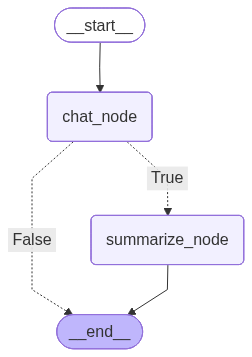

In [10]:
graph

In [21]:
# define a function to run by turns
config = {"configurable": {"thread_id": "t1"}}

def run_turn(text: str):
    out = graph.invoke({"messages": [HumanMessage(content=text)], "summary": ""}, config=config)
    return out

In [22]:
# gives the current version of the state
def show_state():
    snap = graph.get_state(config)
    vals = snap.values
    print("\n--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])

In [23]:
run_turn('Quantum Mechanics')
show_state()

[HumanMessage(content='Quantum Mechanics', additional_kwargs={}, response_metadata={}, id='89056481-0a41-4c27-b6df-a8230d2dea96')]

--- STATE ---
summary: 
num_messages: 2
messages:
- HumanMessage : Quantum Mechanics
- AIMessage : Quantum mechanics is a fundamental theory in physics that describes the behavior


In [24]:
run_turn('How is Albert Einstein related')
show_state()

[HumanMessage(content='Quantum Mechanics', additional_kwargs={}, response_metadata={}, id='89056481-0a41-4c27-b6df-a8230d2dea96'), AIMessage(content='Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy on very small scales, such as atoms and subatomic particles. It is one of the most successful and widely tested theories in science, providing a deep understanding of the nature of matter and the interactions between particles.\n\nKey concepts in quantum mechanics include the wave-particle duality of matter, the uncertainty principle, and quantum superposition. These concepts challenge our classical notions of reality and lead to counterintuitive phenomena such as quantum entanglement, where particles can become correlated and influence each other instantaneously over large distances.\n\nQuantum mechanics has also led to the development of important technologies, such as semiconductors, lasers, and superconductors, that have revolutionize

In [ ]:
run_turn('What are some of Einstien"s famous work')
show_state()

[HumanMessage(content='Quantum Mechanics', additional_kwargs={}, response_metadata={}, id='89056481-0a41-4c27-b6df-a8230d2dea96'), AIMessage(content='Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy on very small scales, such as atoms and subatomic particles. It is one of the most successful and widely tested theories in science, providing a deep understanding of the nature of matter and the interactions between particles.\n\nKey concepts in quantum mechanics include the wave-particle duality of matter, the uncertainty principle, and quantum superposition. These concepts challenge our classical notions of reality and lead to counterintuitive phenomena such as quantum entanglement, where particles can become correlated and influence each other instantaneously over large distances.\n\nQuantum mechanics has also led to the development of important technologies, such as semiconductors, lasers, and superconductors, that have revolutionize

In [26]:
run_turn('Explain special theory of relativity')
show_state()

[HumanMessage(content='Quantum Mechanics', additional_kwargs={}, response_metadata={}, id='89056481-0a41-4c27-b6df-a8230d2dea96'), AIMessage(content='Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy on very small scales, such as atoms and subatomic particles. It is one of the most successful and widely tested theories in science, providing a deep understanding of the nature of matter and the interactions between particles.\n\nKey concepts in quantum mechanics include the wave-particle duality of matter, the uncertainty principle, and quantum superposition. These concepts challenge our classical notions of reality and lead to counterintuitive phenomena such as quantum entanglement, where particles can become correlated and influence each other instantaneously over large distances.\n\nQuantum mechanics has also led to the development of important technologies, such as semiconductors, lasers, and superconductors, that have revolutionize